In [1]:
![ -d QAOAKit ] || git clone https://github.com/melody0123/QAOAKit.git

import os
os.chdir("QAOAKit")
print(os.getcwd()) # debugging output

!pip install --upgrade pip
!pip install .

os.chdir("..")
print(os.getcwd()) # debugging output

/home/melody/my_files/wisc/25Spring/cs639/cs639-dRET/QAOAKit
  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Processing /home/melody/my_files/wisc/25Spring/cs639/cs639-dRET/QAOAKit
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached qiskit-1.3.3-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit_aer-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.1 kB)
  Using cached pynauty-1.1.2-cp310-cp310-manylinux_2_35_x86_64.whl.metadata (5.7 kB)
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached qiskit_optimization-0.6.1-py3-none-any.whl.metadat

In [10]:
!pip install --upgrade pip
!pip install pyzx
!pip install 'trasyn[qiskit,cupy-cuda12]'
!pip install matplotlib pylatexenc

  Using cached pyzx-0.9.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached pyperclip-1.9.0-py3-none-any.whl
  Using cached ipywidgets-8.1.6-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.14-py3-none-any.whl.metadata (4.1 kB)
Using cached pyzx-0.9.0-py3-none-any.whl (358 kB)
Using cached ipywidgets-8.1.6-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.14-py3-none-any.whl (213 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [pyzx]4/5 [pyzx]


In [3]:
!python -m QAOAKit.build_tables

Building tables (this may take a few minutes)...
Loading data, this may take a while
Building graph2angles table...
  0%|                                                     | 0/2 [00:00<?, ?it/s]
                                                                                
  0%|                                                     | 0/6 [00:00<?, ?it/s]
                                                                                
  0%|                                                    | 0/21 [00:00<?, ?it/s]
                                                                                
  0%|                                                   | 0/112 [00:00<?, ?it/s]
                                                                                
  0%|                                                   | 0/853 [00:00<?, ?it/s]
                                                                                
  0%|                                                     | 0/3 [00:00<?, 

In [26]:
import os
import networkx as nx
from qiskit import qpy
from qiskit_aer import AerSimulator
from QAOAKit import opt_angles_for_graph, angles_to_qaoa_format
from QAOAKit.qaoa import get_maxcut_qaoa_circuit

compute_on_the_fly = False

nodes = range(10, 16, 2)
degrees = range(3, 10)

try:
    os.makedirs('algo_level_qc')
except Exception as e:
    print(f"exception happens {e}")

algo_qcs = {}
algo_total_gate_counts = {}
algo_depths = {}
for n in nodes:
    algo_qcs[n] = {}
    algo_total_gate_counts[n] = {}
    algo_depths[n] = {}
    for d in degrees:
        if compute_on_the_fly:
            # build a random 3-regular graph with 10 nodes
            graph = nx.random_regular_graph(d=d, n=n, seed=314)

            # grab optimal angles
            p = 3
            angles = angles_to_qaoa_format(opt_angles_for_graph(graph,p))

            # build circuit
            qc = get_maxcut_qaoa_circuit(graph, angles['beta'], angles['gamma'])

            # remove save_state operation
            new_qc = qc.copy_empty_like()
            for inst in qc:
                op = inst.operation
                if op.name != 'save_state':
                    new_qc.append(op, inst.qubits, inst.clbits)
            qc = new_qc
            
            # save circuit
            algo_qcs[n][d] = qc
            with open(f'./algo_level_qc/{n}_{d}.qpy', 'wb') as qc_file:
                qpy.dump(qc, qc_file)
        else:
            # read circuit
            with open(f'./algo_level_qc/{n}_{d}.qpy', 'rb') as qc_file:
                algo_qcs[n][d] = qpy.load(qc_file)[0]

        # get gate counts
        print(f'{n} nodes {d}-regular: {dict(algo_qcs[n][d].count_ops())}')

        # collect total gate counts
        algo_total_gate_counts[n][d] = sum(algo_qcs[n][d].count_ops().values())

        # collect circuit depth
        algo_depths[n][d] = algo_qcs[n][d].depth()

exception happens [Errno 17] File exists: 'algo_level_qc'
10 nodes 3-regular: {'cx': 90, 'u1': 75, 'u2': 70}
10 nodes 4-regular: {'cx': 120, 'u1': 90, 'u2': 70}
10 nodes 5-regular: {'cx': 150, 'u1': 105, 'u2': 70}
10 nodes 6-regular: {'cx': 180, 'u1': 120, 'u2': 70}
10 nodes 7-regular: {'cx': 210, 'u1': 135, 'u2': 70}
10 nodes 8-regular: {'cx': 240, 'u1': 150, 'u2': 70}
10 nodes 9-regular: {'cx': 270, 'u1': 165, 'u2': 70}
12 nodes 3-regular: {'cx': 108, 'u1': 90, 'u2': 84}
12 nodes 4-regular: {'cx': 144, 'u1': 108, 'u2': 84}
12 nodes 5-regular: {'cx': 180, 'u1': 126, 'u2': 84}
12 nodes 6-regular: {'cx': 216, 'u1': 144, 'u2': 84}
12 nodes 7-regular: {'cx': 252, 'u1': 162, 'u2': 84}
12 nodes 8-regular: {'cx': 288, 'u1': 180, 'u2': 84}
12 nodes 9-regular: {'cx': 324, 'u1': 198, 'u2': 84}
14 nodes 3-regular: {'cx': 126, 'u1': 105, 'u2': 98}
14 nodes 4-regular: {'cx': 168, 'u1': 126, 'u2': 98}
14 nodes 5-regular: {'cx': 210, 'u1': 147, 'u2': 98}
14 nodes 6-regular: {'cx': 252, 'u1': 168, 'u

In [27]:
from qiskit import transpile, qpy

try:
    os.makedirs('opt_algo_qc')
except Exception as e:
    print(f"exception happens {e}")

# optimize circuit with transpilers
opt_algo_qcs = {}
opt_algo_total_gate_counts = {}
opt_algo_depths = {}
for n in nodes:
    opt_algo_qcs[n] = {}
    opt_algo_total_gate_counts[n] = {}
    opt_algo_depths[n] = {}
    for d in degrees:
        if compute_on_the_fly:
            # optimize with qiskit
            opt_algo_qcs[n][d] = transpile(algo_qcs[n][d], optimization_level=3)
            
            # save to files
            with open(f'./opt_algo_qc/{n}-{d}.qpy', 'wb') as qc_file:
                qpy.dump(opt_algo_qcs[n][d], qc_file)
        else:
            # read from file
            with open(f'./opt_algo_qc/{n}-{d}.qpy', 'rb') as qc_file:
                opt_algo_qcs[n][d] = qpy.load(qc_file)[0]

        # get gate counts
        print(f'{n} nodes {d}-regular: {dict(opt_algo_qcs[n][d].count_ops())}')

        # get total gate counts
        opt_algo_total_gate_counts[n][d] = sum(opt_algo_qcs[n][d].count_ops().values())

        # get circuit depth
        opt_algo_depths[n][d] = opt_algo_qcs[n][d].depth()

exception happens [Errno 17] File exists: 'opt_algo_qc'
10 nodes 3-regular: {'cx': 90, 'u1': 45, 'u3': 30, 'u2': 10}
10 nodes 4-regular: {'cx': 120, 'u1': 60, 'u3': 30, 'u2': 10}
10 nodes 5-regular: {'cx': 150, 'u1': 75, 'u3': 30, 'u2': 10}
10 nodes 6-regular: {'cx': 180, 'u1': 90, 'u3': 30, 'u2': 10}
10 nodes 7-regular: {'cx': 210, 'u1': 105, 'u3': 30, 'u2': 10}
10 nodes 8-regular: {'cx': 240, 'u1': 120, 'u3': 30, 'u2': 10}
10 nodes 9-regular: {'cx': 270, 'u1': 135, 'u3': 30, 'u2': 10}
12 nodes 3-regular: {'cx': 108, 'u1': 54, 'u3': 36, 'u2': 12}
12 nodes 4-regular: {'cx': 144, 'u1': 72, 'u3': 36, 'u2': 12}
12 nodes 5-regular: {'cx': 180, 'u1': 90, 'u3': 36, 'u2': 12}
12 nodes 6-regular: {'cx': 216, 'u1': 108, 'u3': 36, 'u2': 12}
12 nodes 7-regular: {'cx': 252, 'u1': 126, 'u3': 36, 'u2': 12}
12 nodes 8-regular: {'cx': 288, 'u1': 144, 'u3': 36, 'u2': 12}
12 nodes 9-regular: {'cx': 324, 'u1': 162, 'u3': 36, 'u2': 12}
14 nodes 3-regular: {'cx': 126, 'u1': 63, 'u3': 42, 'u2': 14}
14 nodes

In [42]:
import matplotlib.pyplot as plt

# draw diagram
def draw_diagram(dataset: dict, line_index: list[int], x: list[int], colors: list[str], line_labels: list[str], ylable: str, figname: str):
    # Visualization setup
    if len(line_index) != len(colors):
        raise IndexError
    else:
        colors = dict(zip(line_index, colors))
    if len(line_index) != len(line_labels):
        raise IndexError
    else:
        line_labels = dict(zip(line_index, line_labels))

    # Plot
    plt.figure(figsize=(10, 6))
    for num in line_index:
        y = list(dataset[num].values())
        plt.plot(list(x), y, marker='o', color=colors[num], label=line_labels[num])

    plt.xlabel("Edges per Vertex (id)")
    plt.ylabel(ylable)
    plt.title(f"{ylable} vs. Graph Connectivity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

def draw_comp_diagram(dataset1: dict, dataset2: dict, line_index: list[int], x: list[int], colors: list[str], line_labels1: list[str], line_labels2: list[str], ylable: str, figname: str):
    # Visualization setup
    if len(line_index) != len(colors):
        raise IndexError
    else:
        colors = dict(zip(line_index, colors))
    if len(line_index) != len(line_labels1):
        raise IndexError
    else:
        line_labels1 = dict(zip(line_index, line_labels1))
    if len(line_index) != len(line_labels2):
        raise IndexError
    else:
        line_labels2 = dict(zip(line_index, line_labels2))

    # Plot
    plt.figure(figsize=(10, 6))
    for num in line_index:
        y1 = list(dataset1[num].values())
        y2 = list(dataset2[num].values())
        plt.plot(list(x), y1, marker='o', color=colors[num], label=line_labels1[num])
        plt.plot(list(x), y2, marker='o', color=colors[num], label=line_labels2[num], linestyle='dashed')

    plt.xlabel("Edges per Vertex (id)")
    plt.ylabel(ylable)
    plt.title(f"{ylable} vs. Graph Connectivity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

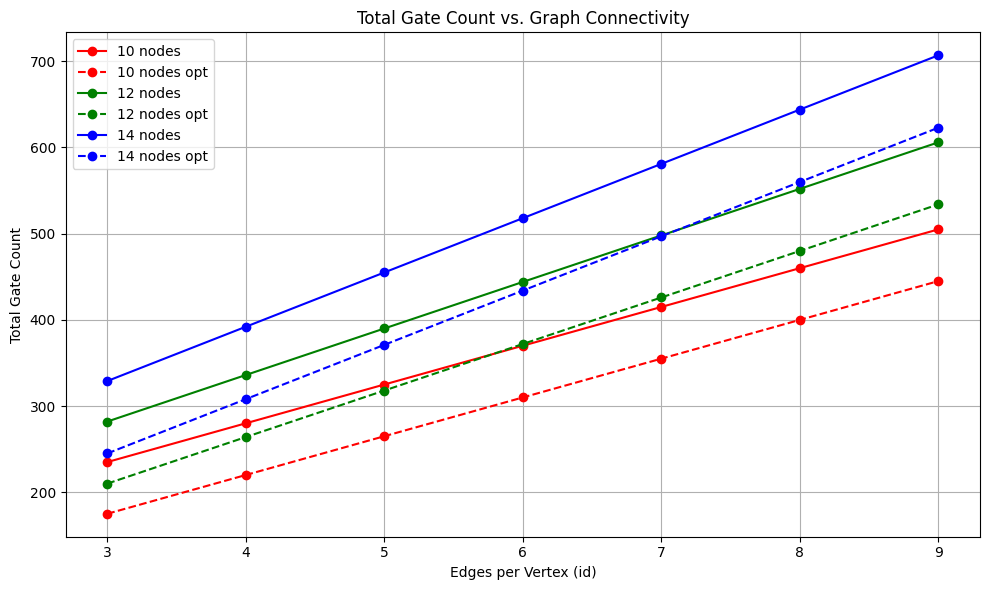

In [43]:
# compare total gate counts
colors = ['r', 'g', 'b']
line_labels_before = ['10 nodes', '12 nodes', '14 nodes']
line_labels_after = ['10 nodes opt', '12 nodes opt', '14 nodes opt']
draw_comp_diagram(algo_total_gate_counts, opt_algo_total_gate_counts, nodes, degrees, colors, line_labels_before, line_labels_after, 'Total Gate Count', 'algo_gate_count.svg')

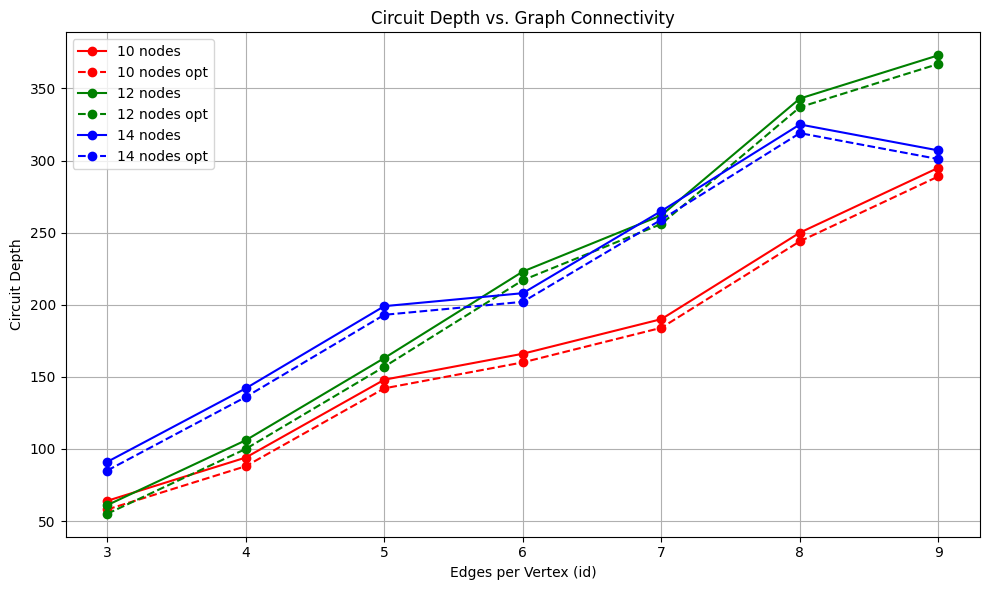

In [44]:
# draw diagram for circuit depth
draw_comp_diagram(algo_depths, opt_algo_depths, nodes, degrees, colors, line_labels_before, line_labels_after, 'Circuit Depth', 'algo_depth.svg')

In [32]:
import time
import pickle
import trasyn
from qiskit import qpy
from qiskit.quantum_info import Statevector, state_fidelity

try:
    os.makedirs('syned_qc')
except Exception as e:
    print(f"exception happens {e}")

# optimize t-gate count with transyn
syned_qcs = {}
runtimes = {}
syned_total_gate_counts = {}
syned_depths = {}
for n in nodes:
    syned_qcs[n] = {}
    runtimes[n] = {}
    syned_total_gate_counts[n] = {}
    syned_depths[n] = {}
    for d in degrees:
        if compute_on_the_fly:
            # perform gate synthesis
            start_time = time.time()
            syned_qcs[n][d] = trasyn.synthesize_qiskit_circuit(circuit=opt_algo_qcs[n][d], u3_transpile=True, nonclifford_budget=50)
            runtimes[n][d] = time.time() - start_time
            
            # print runtime
            print(f"runtime: {runtimes[n][d]} seconds")
            
            # dump synthesized circuit to a file
            with open(f'./syned_qc/{n}-{d}.qpy', 'wb') as qc_file:
                qpy.dump(syned_qcs[n][d], qc_file)
        else:
            with open(f'./syned_qc/{n}-{d}.qpy', 'rb') as qc_file:
                syned_qcs[n][d] = qpy.load(qc_file)[0]

        print("gate counts: ", dict(syned_qcs[n][d].count_ops()))

        # save total gate count
        syned_total_gate_counts[n][d] = sum(syned_qcs[n][d].count_ops().values())

        # save circuit depth
        syned_depths[n][d] = syned_qcs[n][d].depth()

        # compute error after synthesis
        original_state = Statevector(algo_qcs[n][d])
        syned_state = Statevector(syned_qcs[n][d])
        fidelity = state_fidelity(state1=original_state, state2=syned_state)
        print(f"state fidelity after synthesis: {fidelity}")

# dump / read runtime to / from a file
if compute_on_the_fly:
    with open('./syned_qc/runtime', 'wb') as time_file:
        pickle.dump(runtimes, time_file)
else:
    with open('./syned_qc/runtime', 'rb') as time_file:
        runtimes = pickle.load(time_file)

exception happens [Errno 17] File exists: 'syned_qc'
gate counts:  {'h': 1609, 't': 1580, 'y': 326, 'x': 251, 'cx': 90, 's': 48, 'z': 8}
state fidelity after synthesis: 0.9999525245444504
gate counts:  {'h': 1956, 't': 1936, 'y': 368, 'x': 314, 'cx': 120, 's': 18, 'z': 10}


state fidelity after synthesis: 0.9998993815907088
gate counts:  {'h': 2503, 't': 2467, 'y': 510, 'x': 416, 'cx': 150, 's': 74, 'z': 48}
state fidelity after synthesis: 0.9997579580627576
gate counts:  {'h': 2622, 't': 2620, 'y': 521, 'x': 385, 'cx': 180, 's': 34, 'z': 9}
state fidelity after synthesis: 0.9998154600846506
gate counts:  {'h': 3668, 't': 3637, 'x': 750, 'y': 512, 'cx': 210, 's': 90, 'z': 11}
state fidelity after synthesis: 0.9997492374737016
gate counts:  {'h': 3446, 't': 3400, 'y': 600, 'x': 585, 'cx': 240, 's': 82}
state fidelity after synthesis: 0.9996505055479745
gate counts:  {'t': 4949, 'h': 4919, 'x': 847, 'y': 756, 'cx': 270, 's': 53, 'z': 36}
state fidelity after synthesis: 0.998027607801602
gate counts:  {'h': 2093, 't': 2072, 'x': 441, 'y': 364, 'cx': 108, 's': 43, 'z': 9}
state fidelity after synthesis: 0.9998720970655354
gate counts:  {'h': 2718, 't': 2682, 'x': 560, 'y': 400, 'cx': 144, 's': 26, 'z': 2}
state fidelity after synthesis: 0.9998690098130556
gat

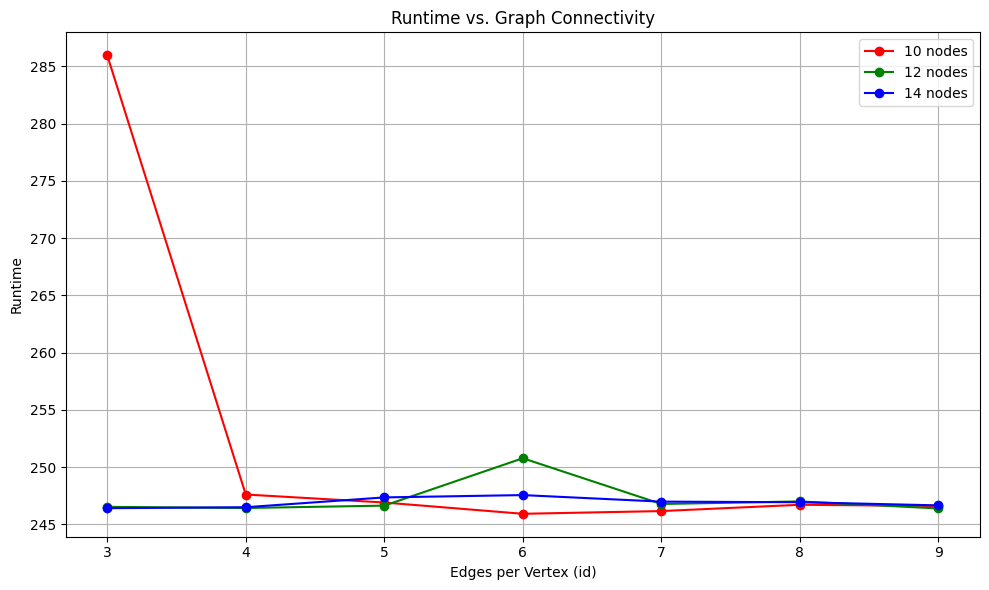

In [45]:
# draw diagram on runtime
colors = ['r', 'g', 'b']
line_labels = ['10 nodes', '12 nodes', '14 nodes']
draw_diagram(runtimes, nodes, degrees, colors, line_labels, 'Runtime', 'syn_runtime.svg')

In [34]:
from qiskit import qasm2
import pyzx as zx

folder_name = 'opt_syned_qc'
try:
    os.makedirs(folder_name)
except Exception as e:
    print(f'exception happens {e}')

opt_syned_qcs = {}
opt_syned_total_gate_counts = {}
opt_syned_depths = {}
for n in nodes:
    opt_syned_qcs[n] = {}
    opt_syned_total_gate_counts[n] = {}
    opt_syned_depths[n] = {}
    for d in degrees:
        final_opt_filename = f'{n}_{d}.qasm'
        if compute_on_the_fly:
            # dump syned_qcs to qasm files
            pre_opt_filename = f'pre_{n}_{d}.qasm'
            qasm2.dump(syned_qcs[n][d], f'./{folder_name}/{pre_opt_filename}')
            
            # load qasm file as pyzx circuit
            zx_circ = zx.Circuit.load(f'./{folder_name}/{pre_opt_filename}')
            os.remove(f'./{folder_name}/{pre_opt_filename}')
            
            # convert to zx-diagram
            g = zx_circ.to_graph()
            zx.teleport_reduce(g)

            # extract circuit from graph
            c_opt = zx.Circuit.from_graph(g)

            # dump circuit to qasm file
            post_opt_filename = f'post_{n}_{d}.qpy'
            with open(f'./{folder_name}/{post_opt_filename}', 'w') as qasm_file:
                qasm_file.write(c_opt.to_qasm())

            # read qasm file to qiskit circuit
            opt_syned_qcs[n][d] = qasm2.load(f'./{folder_name}/{post_opt_filename}', custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
            os.remove(f'./{folder_name}/{post_opt_filename}')
            with open(f'./{folder_name}/{final_opt_filename}', 'wb') as qc_file:
                qpy.dump(opt_syned_qcs[n][d], qc_file)
        else:
            with open(f'./{folder_name}/{final_opt_filename}', 'rb') as qc_file:
                opt_syned_qcs[n][d] = qpy.load(qc_file)[0]

        # print gate counts
        print(dict(opt_syned_qcs[n][d].count_ops()))

        # save total gate counts
        opt_syned_total_gate_counts[n][d] = sum(opt_syned_qcs[n][d].count_ops().values())

        # save circuit depth
        opt_syned_depths[n][d] = opt_syned_qcs[n][d].depth()

exception happens [Errno 17] File exists: 'opt_syned_qc'
{'h': 1609, 't': 1580, 'x': 577, 's': 374, 'sdg': 326, 'cx': 90, 'z': 8}
{'h': 1956, 't': 1936, 'x': 682, 's': 386, 'sdg': 368, 'cx': 120, 'z': 10}
{'h': 2503, 't': 2467, 'x': 926, 's': 584, 'sdg': 510, 'cx': 150, 'z': 48}
{'h': 2622, 't': 2620, 'x': 906, 's': 555, 'sdg': 521, 'cx': 180, 'z': 9}
{'h': 3668, 't': 3637, 'x': 1262, 's': 602, 'sdg': 512, 'cx': 210, 'z': 11}
{'h': 3446, 't': 3400, 'x': 1185, 's': 682, 'sdg': 600, 'cx': 240}


{'t': 4949, 'h': 4919, 'x': 1603, 's': 809, 'sdg': 756, 'cx': 270, 'z': 36}
{'h': 2093, 't': 2072, 'x': 805, 's': 407, 'sdg': 364, 'cx': 108, 'z': 9}
{'h': 2718, 't': 2682, 'x': 960, 's': 426, 'sdg': 400, 'cx': 144, 'z': 2}
{'h': 3079, 't': 3035, 'x': 1106, 's': 731, 'sdg': 667, 'cx': 180, 'z': 2}
{'h': 3265, 't': 3220, 'x': 1024, 's': 632, 'sdg': 587, 'cx': 216, 'z': 42}
{'h': 4320, 't': 4275, 'x': 1524, 's': 772, 'sdg': 727, 'cx': 252, 'z': 1}
{'h': 4997, 't': 4943, 'x': 1569, 's': 933, 'sdg': 837, 'cx': 288, 'z': 4}
{'h': 4989, 't': 4902, 'x': 1762, 's': 1186, 'sdg': 1056, 'cx': 324, 'z': 52}
{'h': 2339, 't': 2316, 'x': 901, 's': 524, 'sdg': 468, 'cx': 126, 'z': 28}
{'h': 2824, 't': 2759, 'x': 987, 's': 654, 'sdg': 620, 'cx': 168, 'z': 44}
{'h': 3545, 't': 3496, 'x': 1313, 's': 804, 'sdg': 681, 'cx': 210, 'z': 2}
{'h': 3704, 't': 3649, 'x': 1085, 's': 609, 'sdg': 494, 'cx': 252, 'z': 33}
{'h': 4889, 't': 4785, 'x': 1625, 's': 1016, 'sdg': 879, 'cx': 294, 'z': 47}
{'h': 5001, 't': 49

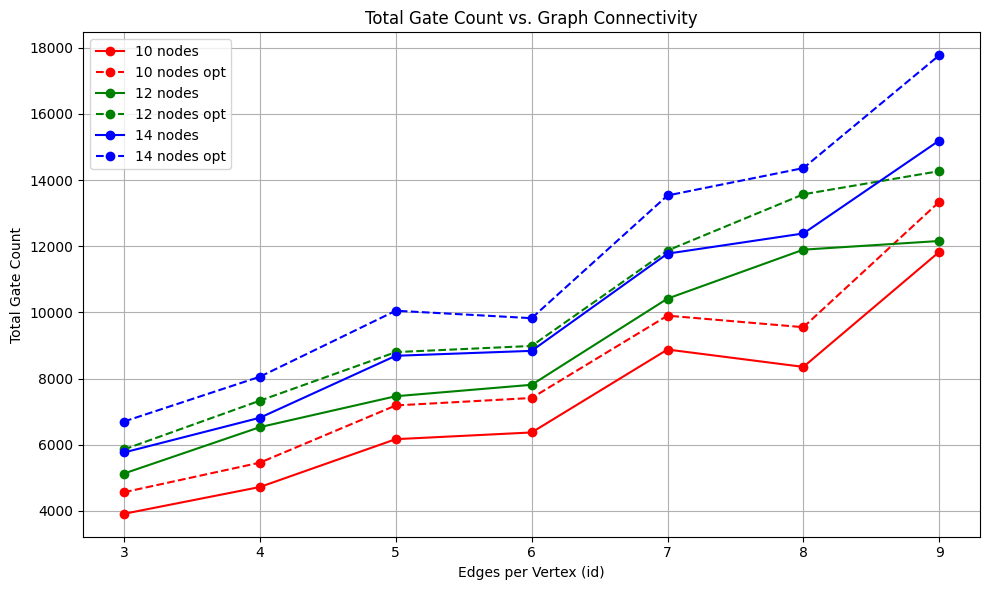

In [46]:
# compare total gate counts
colors = ['r', 'g', 'b']
line_labels_before = ['10 nodes', '12 nodes', '14 nodes']
line_labels_after = ['10 nodes opt', '12 nodes opt', '14 nodes opt']
draw_comp_diagram(syned_total_gate_counts, opt_syned_total_gate_counts, nodes, degrees, colors, line_labels_before, line_labels_after, 'Total Gate Count', 'syned_gate_count.svg')

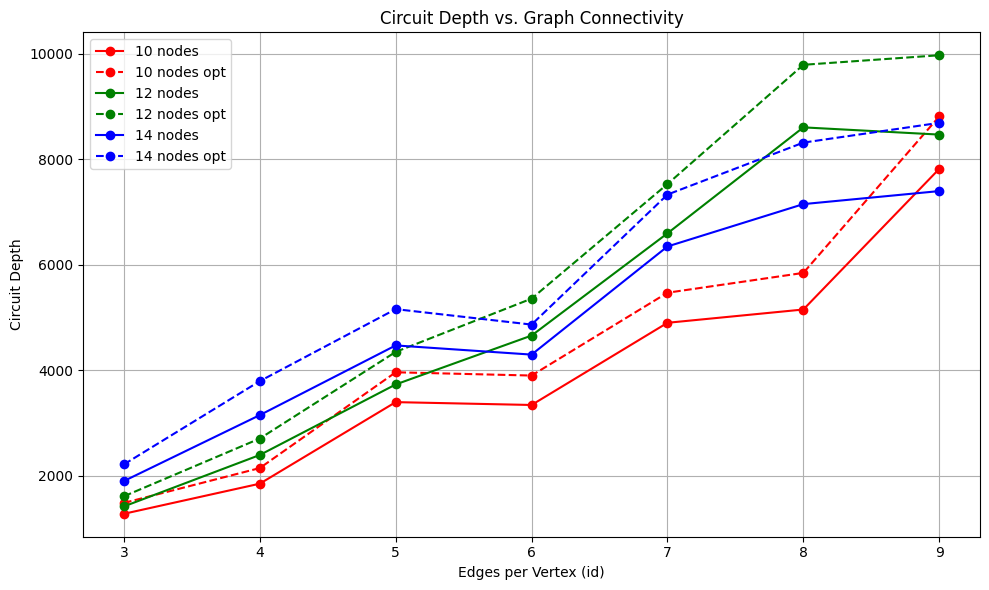

In [47]:
# print circuit depth for optimized circuit
draw_comp_diagram(syned_depths, opt_syned_depths, nodes, degrees, colors, line_labels_before, line_labels_after, 'Circuit Depth', 'syned_depth.svg')